# Gaps on structure functions: demo of pipeline

- Inspired by existing code
- Test on one PSP to start, then two PSP and one Wind for training and testing
- Check against target dataframes as you go

### 0. Import dependencies

In [38]:
import pickle
import pandas as pd
import numpy as np
import ts_dashboard_utils as ts
import src.utils as utils  # copied directly from Reynolds project, normalize() added
import src.params as params
import src.sf_funcs as sf
import sys
import src.data_import_funcs as dif
import json
import glob
import importlib
import matplotlib.pyplot as plt
#plt.rcParams.update({"font.size": 16})
import matplotlib.dates as mdates

In [15]:
# For current Wind importing

sys_arg_dict = {
    # arg1
    "mag_path": params.mag_path,
    "proton_path": params.proton_path,
    "electron_path": params.electron_path,
    # arg2
    "mag_vars": [params.timestamp, params.Bwind, params.Bwind_vec],
    "proton_vars": [params.timestamp, params.np, params.Tp],
    "electron_vars": [params.timestamp, params.ne, params.Te],
    # arg3
    "mag_thresh": params.mag_thresh,
    "proton_thresh": params.proton_thresh,
    "electron_thresh": params.electron_thresh,
    # arg4
    "dt_hr": params.dt_hr,
    "int_size": params.int_size,
    # arg5
    "dt_lr": params.dt_lr,
}

### 1. Download files

Run in terminal

In [16]:
# For selecting a range of dates

# wget --no-clobber --directory-prefix=data/raw/psp  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_20181102{00..12}_v02.cdf
# wget --no-clobber --directory-prefix=data/raw/wind/ https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/2016/wi_h2_mfi_201601{01..07}_v05.cdf

# For entire folders

# wget --no-clobber --directory-prefix=data/raw/psp --recursive -np -nv -nH --cut-dirs=7 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
# wget --no-clobber --directory-prefix=data/raw/wind --recursive -np -nv -nH --cut-dirs=2 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/

### 2. Read in data and split into standardised intervals

#### PSP data

In [16]:
raw_file_list = sorted(glob.iglob("data/raw/psp/" + "/*.cdf"))
print(raw_file_list)

['data/raw/psp\\psp_fld_l2_mag_rtn_2018110200_v02.cdf', 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110206_v02.cdf', 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110212_v02.cdf']


In [17]:
psp_data = dif.read_cdfs(
    [raw_file_list[0]],  # LIMIT HERE!
    {"epoch_mag_RTN": (0), "psp_fld_l2_mag_RTN": (0, 3), "label_RTN": (0, 3)},
)
psp_data_ready = dif.extract_components(
    psp_data,
    var_name="psp_fld_l2_mag_RTN",
    label_name="label_RTN",
    time_var="epoch_mag_RTN",
    dim=3,
)
psp_df = pd.DataFrame(psp_data_ready)
psp_df["Time"] = pd.to_datetime("2000-01-01 12:00") + pd.to_timedelta(
    psp_df["epoch_mag_RTN"], unit="ns"
)
psp_df = psp_df.drop(columns="epoch_mag_RTN").set_index("Time")

df_raw = psp_df["B_R"]

print(df_raw.info())
print(df_raw.head())

reading file  data/raw/psp\psp_fld_l2_mag_rtn_2018110200_v02.cdf
Done reading data
<class 'pandas.core.series.Series'>
DatetimeIndex: 1582027 entries, 2018-11-02 00:01:09.195182976 to 2018-11-02 06:01:09.171900544
Series name: B_R
Non-Null Count    Dtype  
--------------    -----  
1582027 non-null  float64
dtypes: float64(1)
memory usage: 24.1 MB
None
Time
2018-11-02 00:01:09.195182976   -11.061315
2018-11-02 00:01:09.208836480   -10.854164
2018-11-02 00:01:09.222489856   -11.197883
2018-11-02 00:01:09.236143104   -11.008248
2018-11-02 00:01:09.249796352   -11.188342
Name: B_R, dtype: float64


#### Wind data
Takes a while due to large files

In [50]:
# raw_file_list = sorted(glob.iglob("data/raw/wind/" + "/*.cdf"))
# print(raw_file_list)

['data/raw/wind\\wi_h2_mfi_20160101_v05.cdf', 'data/raw/wind\\wi_h2_mfi_20160102_v05.cdf', 'data/raw/wind\\wi_h2_mfi_20160103_v05.cdf', 'data/raw/wind\\wi_h2_mfi_20160104_v05.cdf', 'data/raw/wind\\wi_h2_mfi_20160105_v05.cdf', 'data/raw/wind\\wi_h2_mfi_20160106_v05.cdf', 'data/raw/wind\\wi_h2_mfi_20160107_v05.cdf']


In [53]:
# df = utils.pipeline(
#     raw_file_list[0],
#     varlist=sys_arg_dict["mag_vars"],
#     thresholds=sys_arg_dict["mag_thresh"],
#     cadence=sys_arg_dict["dt_hr"],
# )

# print("Reading {0}: {1:.2f}% missing".format(raw_file_list[0], df.iloc[:,0].isna().sum()/len(df)*100))

# # Ensuring observations are in chronological order
# df_wind_hr = df.sort_index()

# # df_wind_hr = pd.read_pickle("data/processed/" + params.mag_path + params.dt_hr + ".pkl")
# df_wind_hr = df_wind_hr.rename(
#     columns={
#         params.Bwind: "Bwind",
#         params.Bx: "Bx",
#         params.By: "By",
#         params.Bz: "Bz",
#     }
# )

# missing = df_wind_hr.iloc[:, 0].isna().sum() / len(df_wind_hr)

# if missing > 0.4:
#     # Replacing values in lists with na
#     print("Large missing %")
# else:
#     int_wind_hr = df_wind_hr.interpolate().ffill().bfill()

# df_raw = int_wind_hr["Bx"]

# print(df_raw.info())
# print(df_raw.head())

Reading data/raw/wind\wi_h2_mfi_20160101_v05.cdf: 3.02% missing
<class 'pandas.core.series.Series'>
DatetimeIndex: 939130 entries, 2016-01-01 00:00:00 to 2016-01-01 23:59:59.868000
Freq: 92L
Series name: Bx
Non-Null Count   Dtype  
--------------   -----  
939130 non-null  float32
dtypes: float32(1)
memory usage: 10.7 MB
None
Timestamp
2016-01-01 00:00:00.000    5.879855
2016-01-01 00:00:00.092    5.890072
2016-01-01 00:00:00.184    5.862018
2016-01-01 00:00:00.276    5.875757
2016-01-01 00:00:00.368    5.886422
Freq: 92L, Name: Bx, dtype: float32


In [7]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.index[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.2f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}\n".format(np.std(x)))

### 0PTIONAL CODE END ###

No missing data
Length of interval: 1582027
Duration of interval: 0 days 05:59:59.976717568
Duration between some adjacent data points:
0 days 00:00:00.013653376
0 days 00:00:00.013653248
0 days 00:00:00.013653248

Frequency is 73.24 Hz (2dp)
Mean = -28.383399058746512
Standard deviation = 18.777635215345533



In [22]:
tc_approx = 500  # s: 500 for PSP, 2000 for Wind
cadence_approx = 0.1  # s: 0.1 for PSP, 1 for Wind

tc_n = 10  # Number of actual (computed) correlation times we want in our standardised interval...
interval_length = 10000  # ...across this many points

df = df_raw.resample(str(cadence_approx) + "S").mean()

good_inputs_list = []
tc_list = []
cadence_list = []

time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [df],
    nlags=10000,
    plot=False,
)

tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

if tc == -1:
    tc = tc_approx
    new_cadence = tc_n * tc / interval_length
    print(
        f"tc not found for this interval, setting to 500s (default) -> cadence = {new_cadence}s"
    )

else:
    new_cadence = tc_n * tc / interval_length
    print(
        f"tc calculated to be {np.round(tc,2)}s -> cadence = {np.round(new_cadence,2)}s (for {tc_n}tc across {interval_length} points)"
    )

tc_list.append(tc)
cadence_list.append(new_cadence)

try:
    interval_approx_resampled = df.resample(
        str(np.round(new_cadence, 3)) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        # Check if interval is complete
        if interval.isnull().sum() > 0:
            print("interval contains missing data even after down-sampling; skipping")
            # Note: due to merging cannot identify specific file with missing data here
            # only file list as here:
            # print("corresponding input file list: ", file_list_split[core])
        else:
            # print("Interval successfully processed")
            int_norm = utils.normalize(interval)
            good_inputs_list.append(int_norm)

except Exception as e:
    print(f"An error occurred: {e}")

if len(good_inputs_list) == 0:
    print("No good inputs found (good_inputs_list is empty). Exiting.")
    exit(1)

# Logarithmically-spaced lags?
# vals = np.logspace(0, 3, 0.25 * len(good_inputs_list[0]))
# lags = np.unique(vals.astype(int))
lags = np.arange(1, 0.25 * len(good_inputs_list[0]))
powers = [0.5, 2]
times_to_gap = 5  # int(sys.argv[3])

print(
    "\nNumber of standardised intervals: ",
    len(good_inputs_list),
    "about to be gapped",
    times_to_gap,
    "times",
)

tc calculated to be 736.2s -> cadence = 0.74s (for 10tc across 10000 points)

Number of standardised intervals:  2 about to be gapped 5 times


Text(0, 0.5, '$B_R$ (nT)')

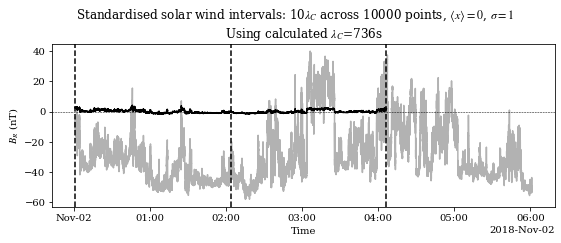

In [19]:
fig, ax = plt.subplots(figsize=(9, 3))
plt.plot(df, alpha=0.3, c="black")
plt.axvline(df.index[0], c="black", linestyle="dashed")
[
    plt.axvline(interval.index[-1], c="black", linestyle="dashed")
    for interval in good_inputs_list
]
[plt.plot(interval, c="black") for interval in good_inputs_list]
plt.axhline(0, c="black", linewidth=0.5, linestyle="--")
plt.suptitle(
    f"Standardised solar wind intervals: {tc_n}$\lambda_C$ across {interval_length} points, $\langle x \\rangle=0$, $\sigma=1$", y= 1.05
)
# # Add subtitle
plt.title(f"Using calculated $\lambda_C$={int(tc)}s")

# ax.set_xlim(interval_list_approx[0].index[0], interval_list_approx[2].index[-1])
ax.set_xlabel("Time")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel("$B_R$ (nT)")
# Tidy the timestamp x-axis
# plt.xticks(rotation=20)

# plt.savefig("plots/int_standardised_demo.png")

In [31]:
raw_interval_metadata = pd.DataFrame({
    "raw_int_start": df.index[0],
    "raw_int_end": df.index[-1],
    "tc": tc_list,
    "cadence": cadence_list,
})
raw_interval_metadata

,raw_int_start,raw_int_end,tc,cadence
0,2018-11-02 00:01:09.100,2018-11-02 06:01:09.100,736.199,0.736199


In [32]:
interval_metadata = pd.DataFrame({
    "int_start": [interval.index[0] for interval in good_inputs_list],
    "int_end": [interval.index[-1] for interval in good_inputs_list],
})
interval_metadata

,int_start,int_end
0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712
1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712


### 3. Calculate the true SF and slope for each interval

In [78]:
good_outputs_list = []
all_bad_inputs_list = []
all_bad_outputs_list = []
all_interp_inputs_list = []
all_interp_outputs_list = []

lags = np.arange(1, 0.1 * len(good_inputs_list[0]))
powers = [0.5, 2]

In [98]:
importlib.reload(sf)

for i, input in enumerate(good_inputs_list):
    # print(f"\nCore {core} processing standardised interval {i}")
    good_output, slope = sf.compute_sf(pd.DataFrame(input), lags, powers, False, False, [10,100])
    good_outputs_list.append(good_output)
    interval_metadata.loc[i, "slope"] = slope

good_outputs_list[0].head()

,lag,n,sf_0.5,missing_percent,sf_0.5_std_err,mapd,diffs_0.5,diffs_0.5_std,sf_2,sf_2_std_err,diffs_2,diffs_2_std,sf_2_ch,sf_2_dowd
1.0,1.0,9999,0.239586,0.0,0.001398,0.045500,"[0.14969090592439616, 0.27161118564872044, 0.1...",0.139777,0.015702,0.000594,"[0.0005020901100550475, 0.005442401847397965, ...",0.059369,0.007209,0.004550
2.0,2.0,9998,0.285889,0.0,0.001679,0.065841,"[0.3101290110356819, 0.29109635627990543, 0.30...",0.167849,0.032877,0.001324,"[0.009250593070561223, 0.00718037419108791, 0....",0.132344,0.014616,0.009528
3.0,3.0,9997,0.311522,0.0,0.001843,0.077117,"[0.3273292775721476, 0.41212882161862596, 0.32...",0.184234,0.047024,0.001895,"[0.011479934442086663, 0.02884907875732225, 0....",0.189428,0.020606,0.013072
4.0,4.0,9996,0.330458,0.0,0.001971,0.086289,"[0.43847181542856734, 0.177845329928834, 0.388...",0.197014,0.059901,0.002304,"[0.036962958966493445, 0.0010003911978191224, ...",0.230391,0.026092,0.016366
5.0,5.0,9995,0.344736,0.0,0.002068,0.092585,"[0.09602913131456206, 0.2781339263303981, 0.00...",0.206721,0.071729,0.002690,"[8.503779702641277e-05, 0.0059843345789084785,...",0.268982,0.030902,0.018841


In [100]:
interval_metadata

,int_start,int_end,slope
0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207
1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743


[]

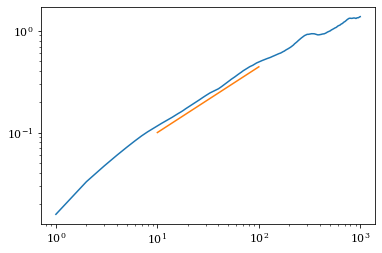

In [99]:
from src.data_import_funcs import pltpwrl
plt.plot(good_outputs_list[0].loc[:, "lag"], good_outputs_list[0].loc[:, "sf_2"])
pltpwrl(10,0.1, 10, 100, interval_metadata.loc[0, "slope"])
plt.semilogx()
plt.semilogy()

### 4. Duplicate, gap and interpolate intervals

### 5. Calculate bad and interpolated SFs and slopes, and error relative to true values

### 6. For PSP training set, create 2D and 3D heatmaps and export

### 7. For PSP and Wind test sets, apply the correction factor and calculate slopes

### 8. Again calculate errors relative to true values